# Training Mask RCNN to instance-segment food images and estimate the calorie content


This notebook was used to train the model, 
If you want to **Train** one can execute from the start 

If you want to **Detect** one can execute from detection & infrence heading after downloading the weights

In [ ]:
import ast
from imageio.plugins import fits
!git clone https://github.com/matterport/Mask_RCNN

### Downloading the Dataset with necessary annotations
This is UNIMIB2016 food dataset, this is prepared by University of Milano-Bicocca,Italy.
The dataset contained 1027 instance-segmented images and contained 73 food classes,however given the number of dataset the number of class is quite large so the food classes only occuring less than 90times were excluded and some varietes of "pasta" were merged into single class name so that model could learn faster and better from available set of data.

---


The dataset of 1027 was divided into train and validation category so that it could be used to train and analyse validate the model every epoch.

---


The dataset annotations were given in a MATLAB file which was couldn't be parsed using just python and neither did the octave so, I had to use MATLAB to open the file and scrap the annotations data off of it to a text file and then to a JSON format.




In [ ]:
%cd Mask_RCNN/
!git clone https://github.com/binayakpokhrel/datasets

### Cloning the main application folder from github

In [ ]:
%cd /content/Mask_RCNN/samples
# !rm -R food_mask
!git clone https://github.com/binayakpokhrel/food_mask
% cd food_mask

### Imports and refrences

In [1]:
import random
import os
import sys


ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)  # To find local version of the library


from food_mask import food
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "Thesis_Code\\logs")

c:\users\matte\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\matte\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\matte\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\matte\anaconda3\envs\mask_rcnn\lib\site-packages\ten

## Setting the custom configurations for food images from food.py file
- smaller anchor scales are added in place of bigger anchors as the image objects are relatively smaller
-2 images are trained in one time
-number of classes added
- validation steps changed to 10

In [2]:
config = food.FoodConfig()
FOOD_DIR = os.path.join(ROOT_DIR, "Thesis_Code\\datasets\\MalteseFood_Dataset_Final\\augmented\\Config3")


### Preview of the available dataset
-dataset.prepare() prepares the class_names ,class_ids and refrences to image paths

In [3]:
dataset = food.FoodDataset()
dataset.load_food(FOOD_DIR, "train")

# Must call before using the dataset
dataset.prepare()


print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 966
Class Count: 8
  0. BG                                                
  1. Pastizz                                           
  2. Imqaret                                           
  3. Gbejniet                                          
  4. Ghaq Tal-Ghasel                                   
  5. Zalzett Malti                                     
  6. Qassatat                                          
  7. Coin                                              


## For training the model is created in training mode with the above config 

In [4]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
%cd /content/Mask_RCNN
!mkdir logs
%cd logs
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

    #uncomment below code to use the pre-trained weights
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ovmfOESjJkpYvPwL4KNnat4i9HA9ftqp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ovmfOESjJkpYvPwL4KNnat4i9HA9ftqp" -O model_044.h5 && rm -rf /tmp/cookies.txt


# Training 
For Training we used coco trained weights to converge faster on a small scale data 
- The learning rate is set to 0.001
- anchor scales were revised to smaller scales (4,8,16,32,64)
- we train 100 steps per epoch
- and take 10 validation steps every epoch


In [5]:

#COCO_MODEL_PATH='/content/Mask_RCNN/logs/mask_rcnn_coco.h5'
COCO_MODEL_PATH='C:\\Users\\matte\\OneDrive\\Desktop\\Thesis\\Thesis_Code\\logs\\mask_rcnn_coco.h5'

###For training there is an option for choosing the weights of 'coco' trained weights or imagenet or the last trained saved model 

In [6]:
init_with = "coco" 
if init_with == "coco":
    #skipping the layers different due to the class numbers
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights("/content/Mask_RCNN/logs/food20190224T0936/mask_rcnn_food_0003.h5", by_name=True)

### The datasets for train and validation is selected from corresponding folders and prepared with the class_names ,class_ids and refrence to image

In [17]:
dataset_train = food.FoodDataset()
dataset_train.load_food(FOOD_DIR, "train")
dataset_train.prepare()

dataset_val = food.FoodDataset()
dataset_val.load_food(FOOD_DIR,"test")
dataset_val.prepare()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\matte\\OneDrive\\Desktop\\Thesis\\Thesis_Code\\datasets\\MalteseFood_Dataset_Final\\augmented\\Config3\\test\\annotation.json'

### Finally the model is trained using the above config and 0.001 learning rate , The original paper suggests 0.002 learning  rate but tf freaks out with 0.002 rate maybe because of the differences in implementation of the optimizers.

- after 40 or so epochs the difference of val_loss and train_loss are quite high so we stop training. 


---


- we train for 47 epochs  
- given the small amount of dataset 47 epochs should be enough to converge.


---


- val_loss of  the epoch 44 is 0.3331 and has small difference with the train_loss so we will take this weight to evaluate


In [8]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4,
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\matte\OneDrive\Desktop\Thesis\Thesis_Code\logs\food20220306T1433\mask_rcnn_food_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b   

c:\users\matte\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
100/100 [==============================] - 8375s 84s/step - loss: 4.5991 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 2.5884 - mrcnn_class_loss: 0.5045 - mrcnn_bbox_loss: 0.7375 - mrcnn_mask_loss: 0.7359 - val_loss: 3.4599 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 2.1756 - val_mrcnn_class_loss: 0.1442 - val_mrcnn_bbox_loss: 0.6351 - val_mrcnn_mask_loss: 0.4974

## Detection using inferenceConfig
First we need to load a model weight in inference mode
- Loading Only one Image on the GPU
- 

In [25]:
class InferenceConfig(food.FoodConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

#create the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path='C://Users//matte//OneDrive//Desktop//Thesis//Thesis_Code//logs//Config3//mask_rcnn_food_0004.h5'
#model_path='C://Users//matte//OneDrive//Desktop//Thesis//Thesis_Code//logs//food20211111T1013//mask_rcnn_food_0001.h5'
print(model_path)
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)

C://Users//matte//OneDrive//Desktop//Thesis//Thesis_Code//logs//Config3//mask_rcnn_food_0004.h5
Loading weights from  C://Users//matte//OneDrive//Desktop//Thesis//Thesis_Code//logs//Config3//mask_rcnn_food_0004.h5


Detection using the trained weights. Here we are choosing a random image from validation dataset and giving 

image_id  266 C:\Users\matte\OneDrive\Desktop\Thesis\Thesis_Code\datasets\MalteseFood_Dataset_Final\augmented\Config3\test\IMG_8761_285.jpg
image                    shape: (2448, 3264, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2448, 3264, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    7.00000  int32
bbox                     shape: (3, 4)                min:  576.00000  max: 2465.00000  int32


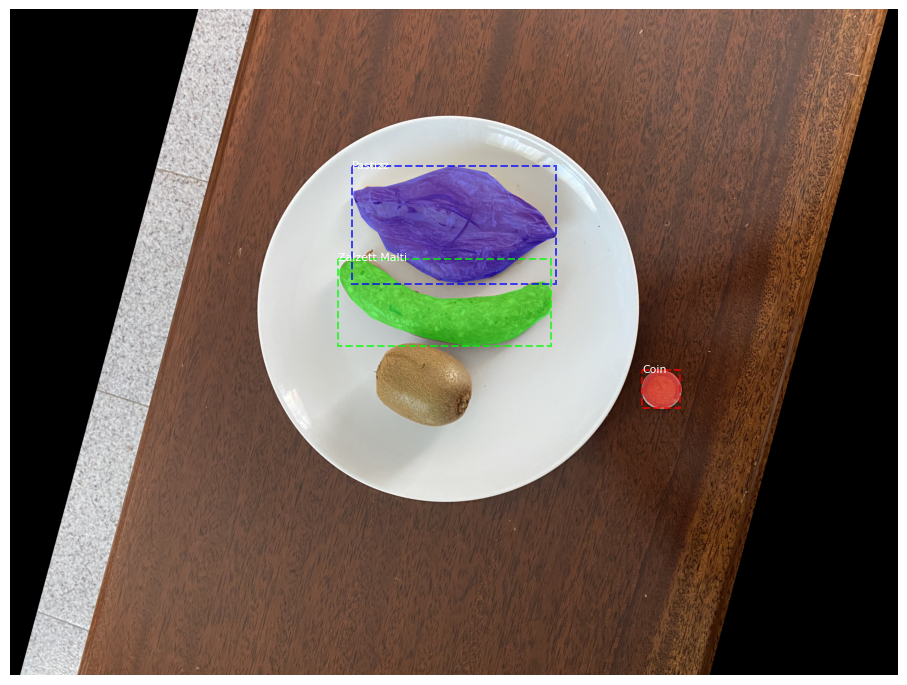

In [14]:
#random.seed(9)

image_id = random.choice(dataset_val
                          .image_ids)

image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_val.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
#("Image Id ",image_id)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_val.class_names)

original_image=image

# Working:
## Plate
 - 3899745 (Plate Pixels)
 - Average grams of each Zalzett = 460g(Total wieght)/4 (Total number of items) = 115g
 - Plate in CM² : d = 26.5, r = 13.25. A= πr² = π·13.25² ≈ 551.54586cm²
 - Proportion of pixels to cm² : (Plate in CM2) : (Plate in Pixels) = 551.54586cm² : 3899745px ∴  1cm² : 7070.572517759449px

## Template For Each Item
 - (Calories per item avg) = 100g : (x = Kcal for 100g) cal ∴  (x)g(AVG of one food item wight : (y)Kcal (y = Kcal for one item weight)
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px (Always standard) ∴  (x)cm² : 345756.00px (size of item mask),
 - (Pixel to calorie ratio) = 345756.00px(Pixels for one item) : 240.34Kcal (Work it out from previous values)
 - (Calorie per CM²) = [7070.572517759449px : ?Kcal] ∴ [7070.57251775944px : (x)Kcal] (Work it out from above ratio)
 - CALORIE/CM² = (x)Kcal/cm²

## Zalzett Malti
 - (Calories per item avg) = 100g : 209Kcal ∴  115g(AVG of one zalzett) : 240.35Kcal
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px ∴  48.90070770528842cm² : 345756.00px,
 - (Pixel to calorie ratio) = 345756.00px(Pixels for one zalzett) : 240.34Kcal
 - (Calorie per CM²) = [7070.572517759449px : ?Kcal] ∴ [7070.57251775944px : 4.914857295081809Kcal]
 - CALORIE/CM² = 4.914857295081809Kcal/cm²

## Imqaret
 - (Calories Per Item avg) = 100g : 302Kcal  ∴  35g(AVG imqaret) : 105.7Kcal
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px(This is the ratio of pixels to cm² from plate)  ∴  39.28776cm² : 277787px (pixels from mask of imqaret)
 - (Pixel to calorie ratio) = 277787px (pixels from mask of imqaret) : 105.7Kcal
 - (Calorie per CM²) = 7070.572517759449px(Pixel equivalent of 1cm²) : ?Kcal , 277787px(Imqaret equivelant in px) : 105.7Kcal  ∴ 7070.572517759449px : 2.6904049330140496kcal
 - IMQARET CALORIE/CM² = 2.6904049330140496Kcal/cm²

 ## Gbejniet
 - (Calories Per Item avg) = 100g : 289Kcal  ∴  90g(AVG gbjeniet) : 260.1Kcal
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px ∴ 31.483730552351496cm² : 222608px
 - (Pixel to calorie ratio) = 222608 :260.1Kcal
 - (Calorie per CM²) = 7070.572517759449px : ?Kcal, 222608px : 260.1Kcal ∴ 7070.572517759449px : 8.261409796005681Kcal
 - GBEJNIET CALORE/CM² = 8.261409796005681Kcal/cm²

 ## Ghaq tal-Ghasel 115
 - (Calories Per Item avg) = 100g : 293Kcal ∴ 115g(AVG Ghaq) : 336.95Kcal
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px ∴ 94.45727320135546cm² : 667867px
 - (Pixel to calorie ratio) = 667867 : 336.95Kcal
 - (Calorie per CM²) = 7070.572517759449px : ?Kcal, 667867px : 336.95Kcal ∴ 7070.572517759449px : 3.5672213327789013Kcal
 - GHAQ TAL-GHASEL CALORE/CM² = 3.5672213327789013Kcal/cm²

 ## Pastizzi
 - (Calories Per Item avg) = 100g : 278Kcal ∴ 60g(AVG Pastizz) : 166.8Kcal
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px ∴ 74.90765403645622cm² : 529640px
 - (Pixel to calorie ratio) = 529640px : 166.8Kcal
 - (Calorie per CM²) = 7070.572517759449px : ?Kcal, 529640px : 166.8Kcal ∴ 7070.572517759449px : 2.2267417414890796Kcal
 - PASTIXXI CALORIE/CM² = 2.2267417414890796Kcal

 ## Qassatat
 - (Calories Per Item avg) = 100g : 269Kcal ∴ 264g(AVG Qassatat) : 710.16Kcal
 - (CM² to pixels ratio) = 1cm² : 7070.572517759449px ∴ 92.20073740316866cm² : 651912px
 - (Pixel to calorie ratio) = 651912px : 710.16Kcal
 - (Calorie per CM²) = 7070.572517759449px : ?Kcal, 651912px : 710.16Kcal ∴ 7070.572517759449px : 7.702324514983695Kcal
 - QASSATAT CALORIE/CM² = 7.702324514983695Kcal

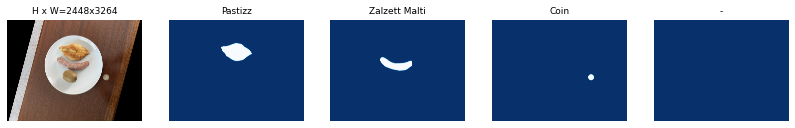

Class : 7
Total Pixels  15409
Class : 5
Total Pixels  128208
Class : 1
Total Pixels  205130


In [15]:
# Printing the Individual masks total pixel sum
import numpy as np
visualize.display_top_masks(image,mask,class_ids,dataset_val.class_names)

for i in class_ids:
    print('Class :',i)
    print('Total Pixels ',mask[:,:,np.where(class_ids == i)[0]].sum())

## Detection Of A single Photo.


3174 Coin
53608 Qassatat
49394 Qassatat


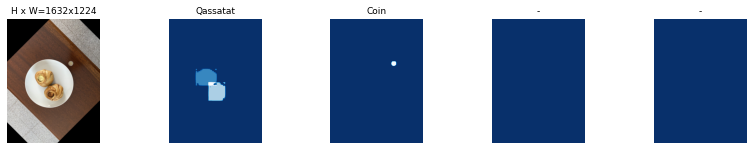

In [38]:
from skimage import io
img_test = io.imread(FOOD_DIR+'\\test\\IMG_8694_225.JPG')
results = model.detect([img_test], verbose=0)
result = results[0]
cls_names = ['BG','Pastizz','Imqaret','Gbejniet','Ghaq Tal-Ghasel','Zalzett Malti','Qassatat','Coin']

for i in range(result['masks'].shape[-1]):
#   print(i)
    masked_food_pixels=result['masks'][:,:,i].sum()
    class_name=cls_names[result['class_ids'][i]]
    print(masked_food_pixels, class_name)

visualize.display_top_masks(img_test,result['masks'],result['class_ids'],cls_names)

#visualize.display_instances(original_image, result['rois'], result['masks'], result['class_ids'],
#                             cls_names, result['scores'])

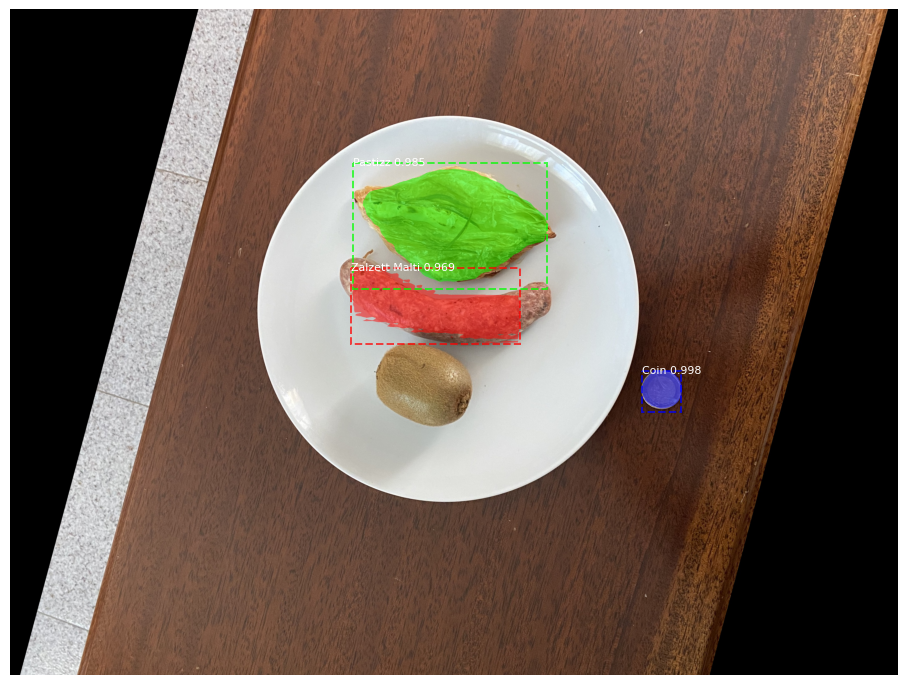

Time Lapsed = 0:0:25.45363974571228
None


In [16]:
import time
def time_convert(sec):
  mins = sec // 60
  sec = sec % 60
  hours = mins // 60
  mins = mins % 60
  print("Time Lapsed = {0}:{1}:{2}".format(int(hours),int(mins),sec))

start_time = time.time()
results = model.detect([original_image], verbose=0)


r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'])

end_time = time.time()
time_lapsed = end_time - start_time
print(time_convert(time_lapsed))

In [13]:
for i in range(r['masks'].shape[-1]):
#   print(i)
    masked_food_pixels=r['masks'][:,:,i].sum()
    class_name=dataset_val.class_names[r['class_ids'][i]]
    print(masked_food_pixels, class_name)

11155 Coin
172911 Qassatat


# Approach Calorie estimation
The calorie estimation requires the weight of the food product to be accurate 

---

As we have only the image with us we need to estimate the weight of the food with the provided image


---

Systems with multiple should find it easy to analyse depth of the food presented but pinhole cameras lack the functionality

---


For this purpose we choose refrencing a known object in the image and computing the size of food in image


---


Using known object surface area  we calculate the 'pixel per inches square" value for the given image which gives off the pixel density for an inch square of real life area so that we can compute the real life  surface area hold by  the shown food item


---

# real_food_area = masked_food_pixel_area / pixels_per_inch

In [ ]:

masked_plate_pixels=1130972
real_plate_size=12
real_plate_area=113.04
pixels_per_inch_sq=masked_plate_pixels/real_plate_area
calories=[]
items=[]
for i in range(r['masks'].shape[-1]):
#   print(i)
  masked_food_pixels=r['masks'][:,:,i].sum()
  class_name=dataset_val.class_names[r['class_ids'][i]]
  real_food_area=masked_food_pixels/pixels_per_inch_sq
  calorie=food.get_calorie(class_name,real_food_area)
  calories.append(calorie)
  items.append(class_name)
  print("{1} with {0} calories".format(int(calorie),class_name))

### Plotting the acquired calories

In [ ]:
import matplotlib as plt
 
# Create a pieplot
plt.pie(calories,labels=items)
#plt.show()
 
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()


# Evaluation of the model
We compute average precision of 40 pictures and print out the average 

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, 40)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
import tensorflow as tf

In [ ]:
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
import numpy as np
visualize.display_images(np.transpose(activations["res3c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
visualize.display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
